In [3]:
!pip install pandas numpy yfinance statsmodels matplotlib


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


Enter the stock ticker symbol (e.g., TSLA for Tesla): AAPL
Enter the prediction date (YY-MM-DD): 24-12-06


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Predicted stock price for AAPL on 2024-12-06: $232.89

Training Performance:
Mean Absolute Error (MAE): 0.59
Mean Squared Error (MSE): 0.75
Root Mean Squared Error (RMSE): 0.87
R² Score: 1.00

Testing Performance:
Mean Absolute Error (MAE): 7.89
Mean Squared Error (MSE): 89.27
Root Mean Squared Error (RMSE): 9.45
R² Score: -1.04


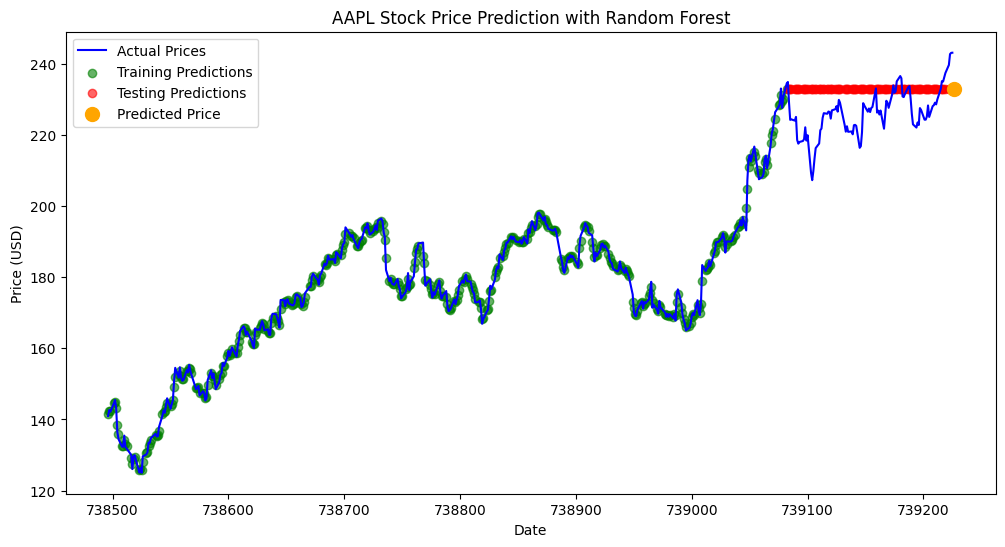

In [5]:
# Function to fetch stock data from Yahoo Finance
def get_data_from_yahoo(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    return data

# Function to evaluate the model performance
def evaluate_model(y_true, y_pred, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{dataset_type} Performance:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

# User input for stock ticker and prediction date
ticker = input("Enter the stock ticker symbol (e.g., TSLA for Tesla): ")
prediction_date_input = input("Enter the prediction date (YY-MM-DD): ")

# Convert the prediction date to a datetime object
try:
    prediction_date = datetime.strptime('20' + prediction_date_input, "%Y-%m-%d").date()
except ValueError:
    print("Invalid date format. Please use the format 'YY-MM-DD'.")
    prediction_date = None

if prediction_date:
    # Calculate the start date (2 years before the prediction date)
    start_date = prediction_date - timedelta(days=2 * 365)
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = prediction_date.strftime("%Y-%m-%d")

    # Fetch stock data
    data = get_data_from_yahoo(ticker, start_date_str, end_date_str)

    # Check if data is sufficient
    if len(data) < 60:
        print("Not enough data available. At least 60 data points are required.")
    else:
        # Prepare the data
        data["Date"] = data.index
        data = data[["Date", "Close"]].dropna()

        # Feature engineering: converting the Date to integer format
        data["Date"] = data["Date"].apply(lambda x: x.toordinal())

        # Define the independent variable (X) and dependent variable (y)
        X = data["Date"].values.reshape(-1, 1)  # Date converted to ordinal as feature
        y = data["Close"].values  # Closing price is the target

        # Train-test split (80% training, 20% testing) - this is done by directly slicing the data
        train_size = int(len(data) * 0.8)  # 80% for training, 20% for testing
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Train Random Forest model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Predict on both training and testing data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Predict stock price for the given prediction date
        prediction_ordinal = pd.Timestamp(prediction_date).toordinal()
        predicted_price = model.predict([[prediction_ordinal]])

        # Display predicted price
        print(f"Predicted stock price for {ticker} on {prediction_date.strftime('%Y-%m-%d')}: ${predicted_price[0]:.2f}")

        # Evaluate the model
        evaluate_model(y_train, y_train_pred, "Training")
        evaluate_model(y_test, y_test_pred, "Testing")

        # Plot actual data and predictions
        plt.figure(figsize=(12, 6))
        plt.plot(data["Date"], y, label="Actual Prices", color="blue")
        plt.scatter(X_train, y_train_pred, label="Training Predictions", color="green", alpha=0.6)
        plt.scatter(X_test, y_test_pred, label="Testing Predictions", color="red", alpha=0.6)
        plt.scatter(prediction_ordinal, predicted_price[0], color="orange", label="Predicted Price", s=100)
        plt.title(f"{ticker} Stock Price Prediction with Random Forest")
        plt.xlabel("Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.show()

else:
    print("Please enter a valid stock ticker symbol.")